# get_terminal_utilization


In [ ]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%f' % x)

In [ ]:
base_url = 'https://api.leviaton.synmax.com/leviaton-be2/v2/'
END_USER_API_KEY="xxxxxxxxxxxxxxxxxxxxxxxx"

In [ ]:
requested_units = 'bcf'
tx_type='loading'
terminal_name='Sabine Pass'
end_point = "query?query_func=get_terminal_utilization&terminal_name="+terminal_name+"&tx_type="+tx_type+"&requested_units="+requested_units

In [ ]:
response = requests.get(base_url + end_point, headers={}, params={"apikey": END_USER_API_KEY} )
print (base_url + end_point)
if response.status_code==200:
    print ("ready!")
    result = response.json()
else:
    print ("oops, something went wrong")

https://api.leviaton.synmax.com/leviaton-be2/v2/query?query_func=get_terminal_utilization&terminal_name=Sabine Pass&tx_type=loading&requested_units=bcf
oops, something went wrong


In [ ]:
data = result['meta']['query_result']['data']
df = pd.DataFrame(data)
df['tx_date_start'] = pd.to_datetime(df['tx_date_start'])

df

,country,imo,terminal,tx_date_start,type,volume,volume_unit
0,USA,9640023,Sabine Pass,2020-01-01 03:00:10,loading,3.240000,bcf
1,USA,9825568,Sabine Pass,2020-01-01 23:00:04,loading,3.540000,bcf
2,USA,9760770,Sabine Pass,2020-01-02 20:00:09,loading,3.600000,bcf
3,USA,9744013,Sabine Pass,2020-01-03 12:00:24,loading,3.110000,bcf
4,USA,9635315,Sabine Pass,2020-01-04 11:02:50,loading,0.590000,bcf
...,...,...,...,...,...,...,...
1683,USA,9401295,Sabine Pass,2024-06-26 02:57:30,loading,1.830000,bcf
1684,USA,9654696,Sabine Pass,2024-06-26 23:57:34,loading,3.240000,bcf
1685,USA,9721736,Sabine Pass,2024-06-28 03:58:37,loading,3.450000,bcf
1686,USA,9758064,Sabine Pass,2024-06-29 01:58:11,loading,3.510000,bcf


## graph it (Multi-Line Plot or Time Series Overlay Plot)


In [ ]:
# Aggregate volume by day
df['date'] = df['tx_date_start'].dt.date
df['tx_date_start'] = pd.to_datetime(df['tx_date_start'])
df['year'] = df['tx_date_start'].dt.year
df['date'] = df['tx_date_start'].dt.date
daily_volume = df.groupby(['year', 'date']).agg({'volume': 'sum'}).reset_index()
daily_volume['date'] = pd.to_datetime(daily_volume['date'])

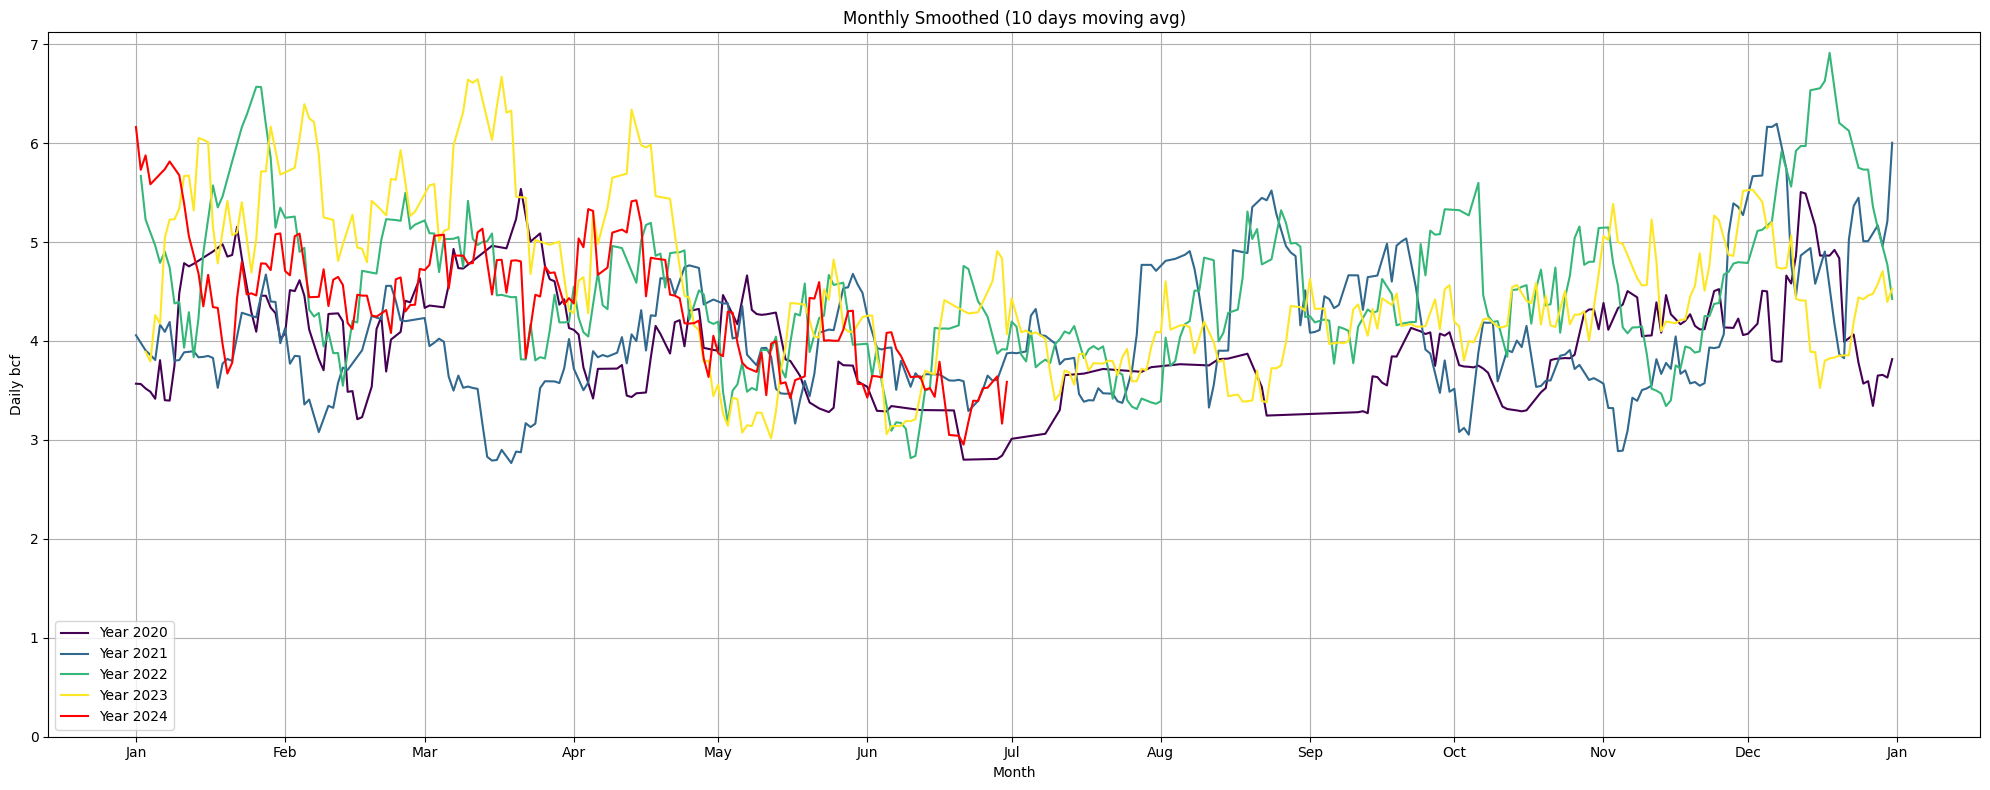

In [ ]:
plt.figure(figsize=(20, 8))

MOVING_AVG = 10
daily_volume['normalized_date'] = daily_volume['date'].apply(lambda x: x.replace(year=2024))  # Normalize dates
most_recent_year = daily_volume['year'].max()

# Colors for plotting, using a color map for all years except the most recent one
color_map = plt.cm.viridis(np.linspace(0, 1, daily_volume['year'].nunique() - 1))
color_dict = {year: color_map[i] for i, year in enumerate(sorted(daily_volume['year'].unique())) if year != most_recent_year}
color_dict[most_recent_year] = 'red'  # Set the most recent year's color to red

for year, group in daily_volume.groupby('year'):
    group = group.sort_values('normalized_date')
    smoothed_data = group.set_index('normalized_date')['volume'].rolling(window=MOVING_AVG, center=True, min_periods=1).mean()
    plt.plot(smoothed_data.index, smoothed_data, label=f'Year {year}', color=color_dict[year])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.ylim(bottom=0)
plt.title('Monthly Smoothed ('+str(MOVING_AVG)+' days moving avg)')
plt.xlabel('Month')
plt.ylabel('Daily '+requested_units)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()